In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import numpy as np


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten


In [3]:
df = pd.read_csv('data/HistoricalQuotes.csv',index_col='Date',parse_dates=True)
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2020-02-28,$273.36,106721200,$257.26,$278.41,$256.37
2020-02-27,$273.52,80151380,$281.1,$286,$272.96
2020-02-26,$292.65,49678430,$286.53,$297.88,$286.5
2020-02-25,$288.08,57668360,$300.95,$302.53,$286.13
2020-02-24,$298.18,55548830,$297.26,$304.18,$289.23


# Basic Preprocess

In [4]:
df[' Close/Last'] = df[' Close/Last'].str.replace('$','').astype(float)
df[' Open'] = df[' Open'].str.replace('$','').astype(float)
df[' High'] = df[' High'].str.replace('$','').astype(float)
df[' Low'] = df[' Low'].str.replace('$','').astype(float)

df.columns = df.columns.str.strip()
df.rename(columns={'Close/Last':'Close'},inplace=True)

# Descriptive Statistics
Descriptive statistic is a summary statistic that quantitatively describes or summarizes features from a collection of structured data.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2020-02-28 to 2010-03-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2518 non-null   float64
 1   Volume  2518 non-null   int64  
 2   Open    2518 non-null   float64
 3   High    2518 non-null   float64
 4   Low     2518 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 118.0 KB


In [6]:
df.describe()

,Close,Volume,Open,High,Low
count,2518.000000,2.518000e+03,2518.000000,2518.000000,2518.000000
mean,114.769522,7.258009e+07,114.728443,115.766415,113.690582
std,60.662405,5.663113e+07,60.546893,61.134456,60.085105
min,29.835700,1.136205e+07,29.392800,29.928600,28.464300
25%,66.822475,3.053026e+07,66.877150,67.475300,66.372950
50%,101.090000,5.295469e+07,101.115000,102.085000,100.350000
75%,154.630000,9.861006e+07,154.610000,155.735000,153.325000
max,327.200000,4.624423e+08,324.740000,327.850000,323.350000


In [7]:
fig = make_subplots(rows=6, cols=1, vertical_spacing=0.02, subplot_titles=('Close Price', 'Open Price', 'High Price', 'Low Price', 'Volume'))

# Add traces for close price 
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Close'), row=1, col=1)


# Add traces for open price
fig.add_trace(go.Scatter(x=df.index, y=df['Open'], mode='lines', name='Open'), row=2, col=1)

# Add traces for high price
fig.add_trace(go.Scatter(x=df.index, y=df['High'], mode='lines', name='High'), row=3, col=1)

# Add traces for low price
fig.add_trace(go.Scatter(x=df.index, y=df['Low'], mode='lines', name='Low'), row=4, col=1)




# Add traces for volume
fig.add_trace(go.Bar(x=df.index, y=df['Volume'], name='Volume'), row=5, col=1)


fig.update_layout(
    title_text='Volume and Price over Time',
    width=1000,   # Set the width of the figure
    height=2000,   # Set the height of the figure
)

# Seasonilty Trend are the timeframes

In [8]:
df['year'] = df.index.year
df['month'] = df.index.month
df = df.reset_index()
df['week'] = df['Date'].apply(lambda x: x.week)
df = df.set_index('Date')
df['day'] = [x for x in df.index.day_of_week]
df['day_str'] = [x.strftime('%a') for x in df.index]
df['year_month'] = [str(x.year) + '_' + str(x.month) for x in df.index]

df

,Close,Volume,Open,High,Low,year,month,week,day,day_str,year_month
Date,,,,,,,,,,,
2020-02-28,273.3600,106721200,257.2600,278.4100,256.3700,2020,2,9,4,Fri,2020_2
2020-02-27,273.5200,80151380,281.1000,286.0000,272.9600,2020,2,9,3,Thu,2020_2
2020-02-26,292.6500,49678430,286.5300,297.8800,286.5000,2020,2,9,2,Wed,2020_2
2020-02-25,288.0800,57668360,300.9500,302.5300,286.1300,2020,2,9,1,Tue,2020_2
2020-02-24,298.1800,55548830,297.2600,304.1800,289.2300,2020,2,9,0,Mon,2020_2
...,...,...,...,...,...,...,...,...,...,...,...
2010-03-05,31.2786,224647427,30.7057,31.3857,30.6614,2010,3,9,4,Fri,2010_3
2010-03-04,30.1014,89591907,29.8971,30.1314,29.8043,2010,3,9,3,Thu,2010_3
2010-03-03,29.9043,92846488,29.8486,29.9814,29.7057,2010,3,9,2,Wed,2010_3


In [9]:
# create a plotting function
def plot_seasonal_graph(df,feature):
    df_plot = df[['year','month',feature]].groupby(['year','month']).mean()[feature].reset_index()
    years = df_plot['year'].unique()
    colors = np.random.choice(list(px.colors.qualitative.Plotly),len(years))
    plt.figure(figsize=(16,12))
    for i,year in enumerate(years):
        df_plot[df_plot['year']==year].plot(x='month',y=feature,ax=plt.gca(),label=year,color=colors[i])
        if year == 2018:
            plt.text(df_plot.loc[df_plot.year==year, :].shape[0]+0.3, df_plot.loc[df_plot.year==year, feature][-1:].values[0], year, fontsize=12, color=colors[i])
        else:
            plt.text(df_plot.loc[df_plot.year==year, :].shape[0]+0.1, df_plot.loc[df_plot.year==year, feature][-1:].values[0], year, fontsize=12, color=colors[i])

    plt.gca().set(ylabel= 'PJME_MW', xlabel = 'Month')
    plt.yticks(fontsize=12, alpha=.7)
    plt.title("Seasonal Plot - Monthly Consumption", fontsize=20)
    plt.ylabel('Consumption [MW]')
    plt.xlabel('Month')
    plt.show()



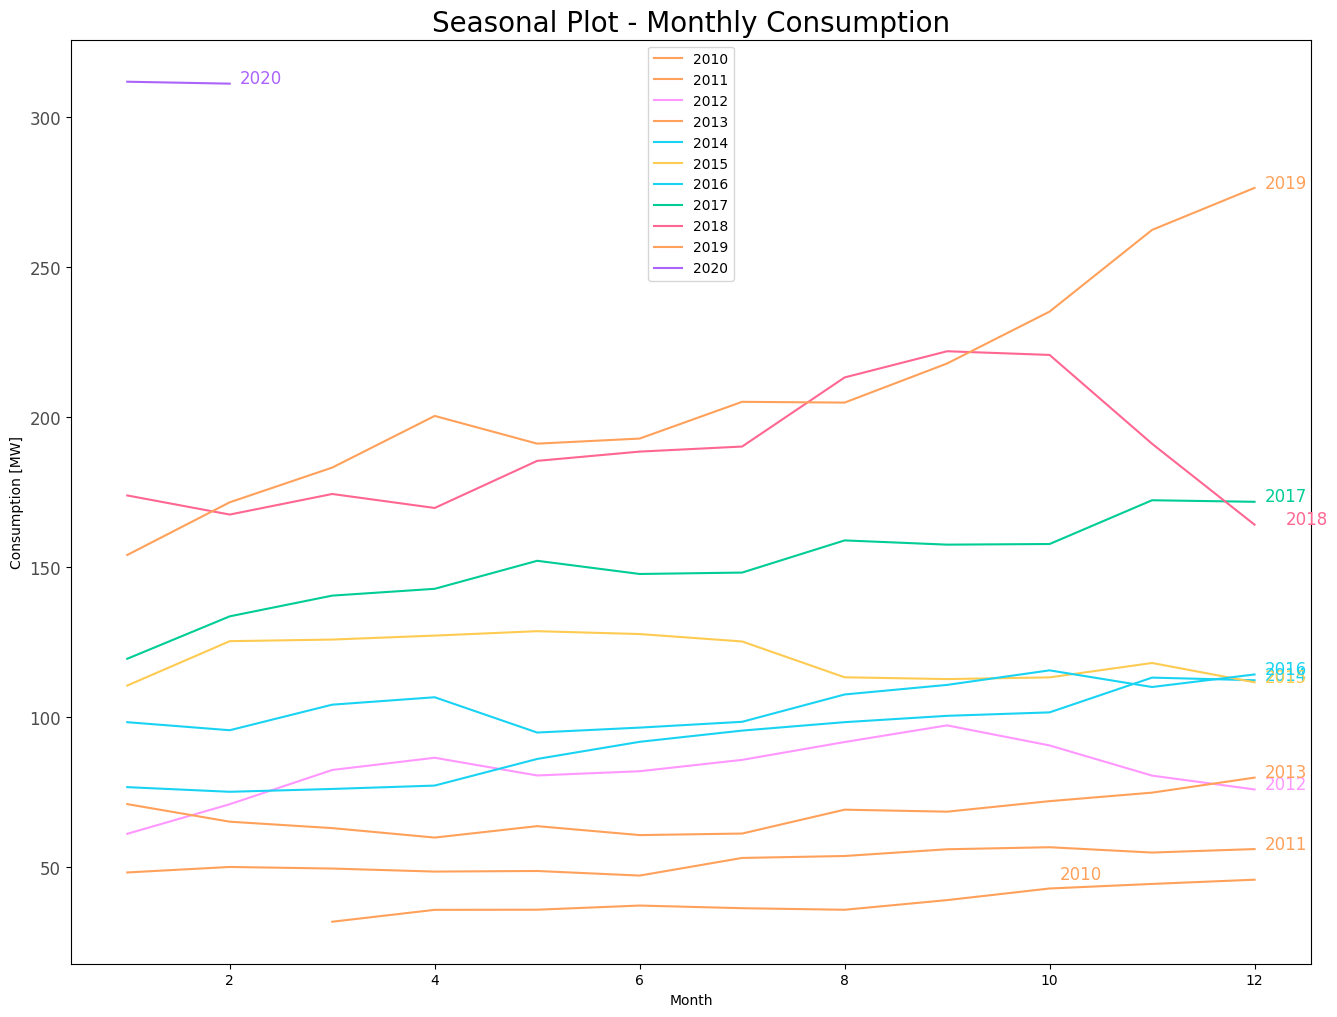

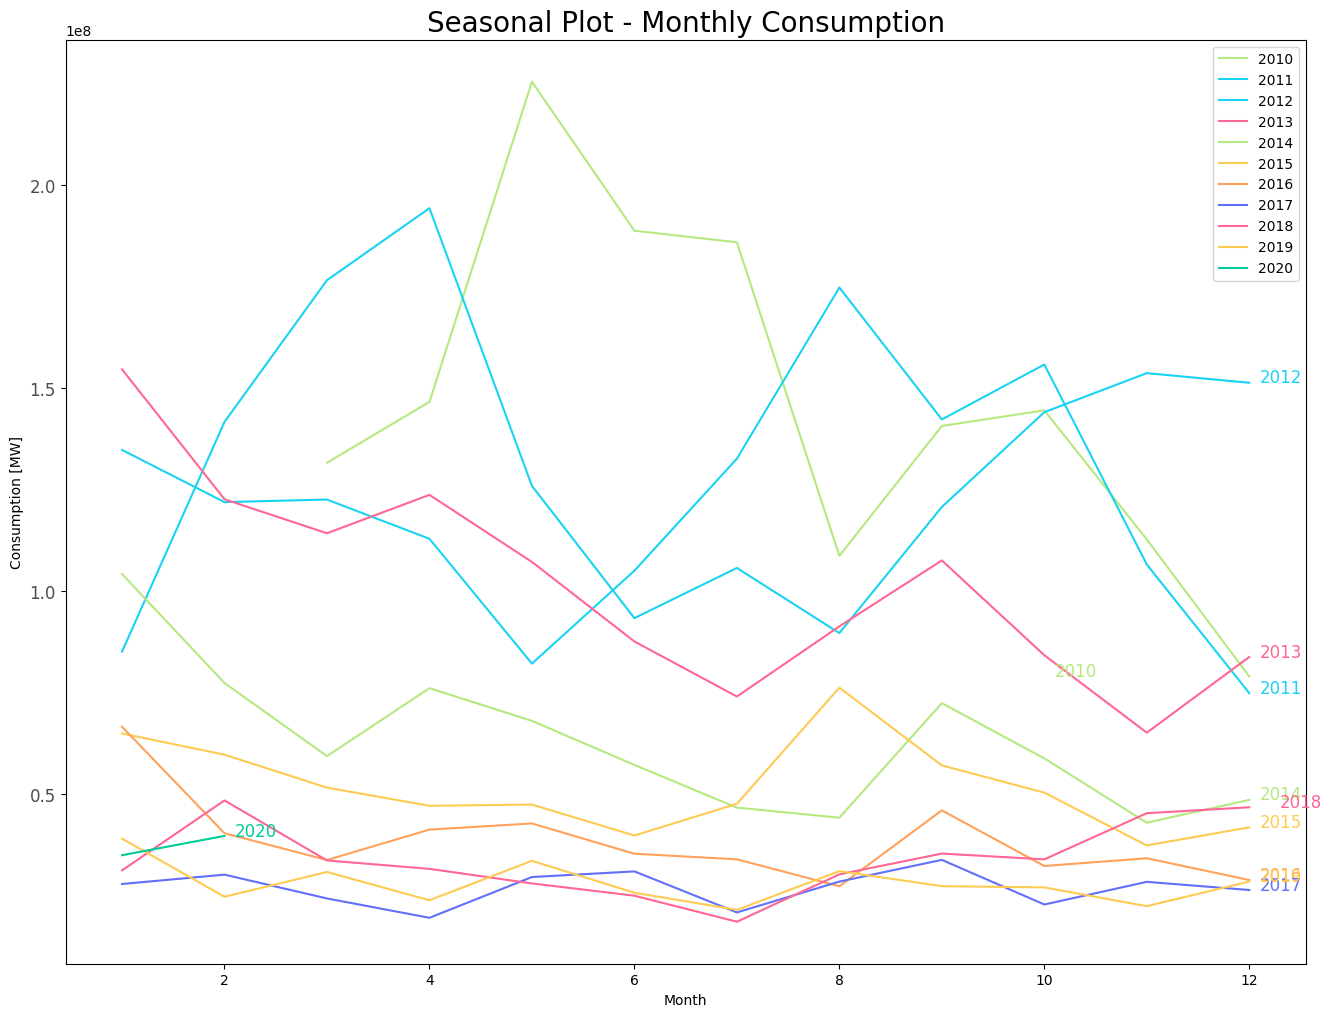

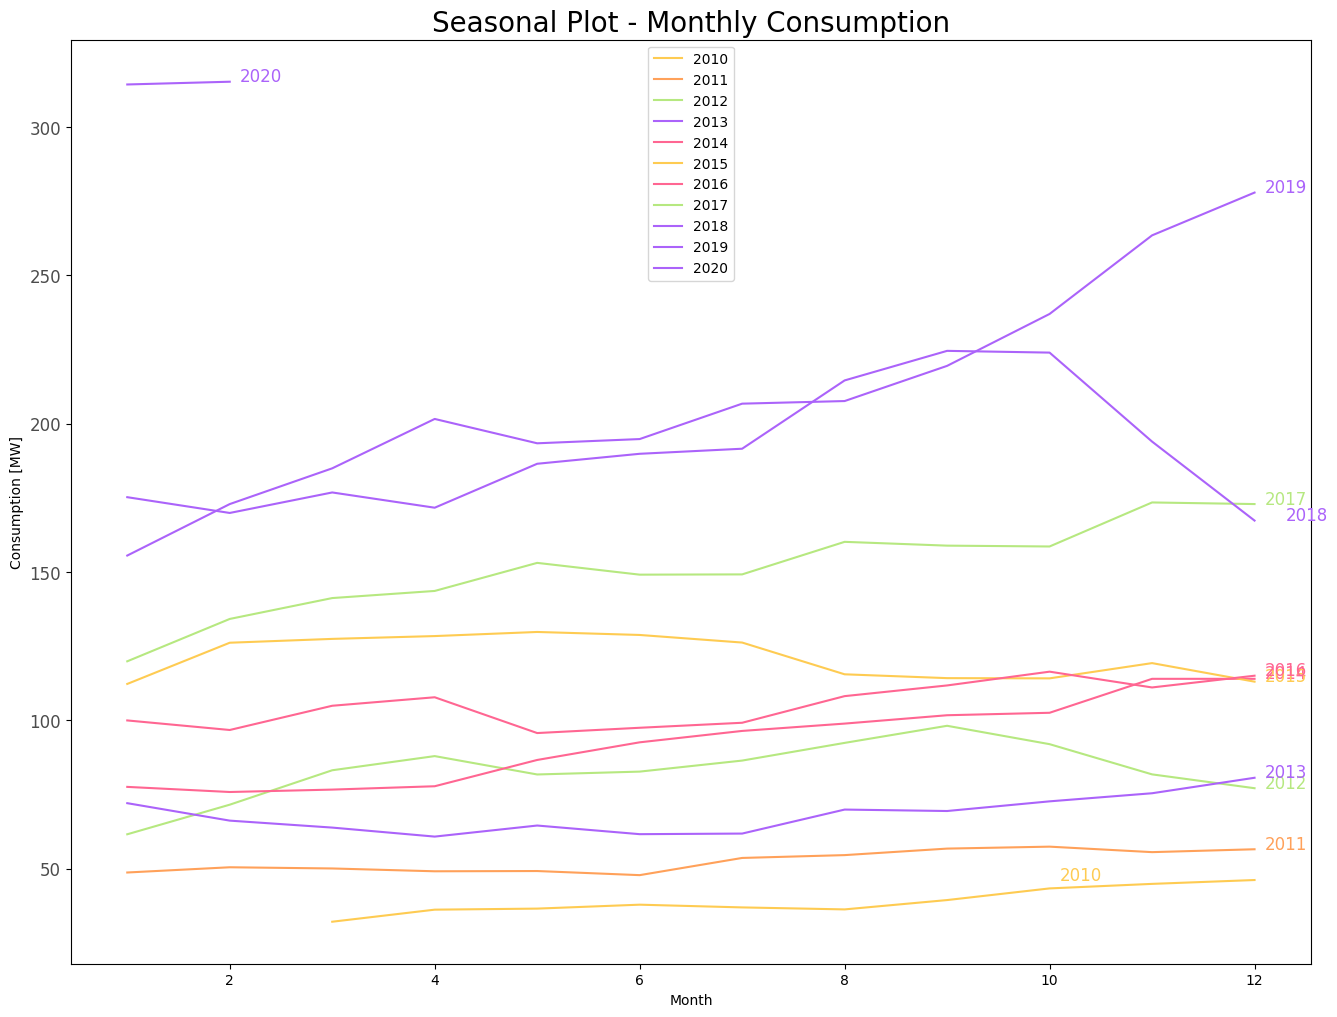

In [10]:
plot_seasonal_graph(df,'Close')
plot_seasonal_graph(df,'Volume')
plot_seasonal_graph(df,'High')

# BOXPLOT 

In [11]:
import plotly.express as px

def generate_boxplot(df, x_col, y_col, title, width=1000, height=600):
    """
    Generates a robust boxplot using Plotly Express.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - x_col (str): Column name for the x-axis (categorical or temporal).
    - y_col (str): Column name for the y-axis (numerical).
    - title (str): Title of the boxplot.
    - width (int): Width of the plot (default=1000).
    - height (int): Height of the plot (default=600).

    Returns:
    - fig (plotly.graph_objects.Figure): Generated boxplot.
    """
    fig = px.box(
        df, 
        x=x_col, 
        y=y_col, 
        title=title, 
        width=width, 
        height=height
    )
    # Update layout for better visuals
    fig.update_layout(
        title_font_size=18,
        xaxis_title=x_col.capitalize(),
        yaxis_title=y_col.capitalize(),
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        font=dict(family="Arial, sans-serif", size=14)
    )
    return fig

# Sample usage
def create_all_boxplots(df, columns, x_col="year"):
    """
    Creates and displays boxplots for multiple y-columns against a common x-column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - columns (list): List of column names (numerical) to create boxplots for.
    - x_col (str): Column name for the x-axis (default="year").
    """
    for col in columns:
        title = f"Boxplot of {col.capitalize()} over {x_col.capitalize()}"
        fig = generate_boxplot(df, x_col=x_col, y_col=col, title=title)
        fig.show()

# Example columns to plot
columns_to_plot = ["Close", "Volume", "High", "Low"]

# Create boxplots for these columns
create_all_boxplots(df, columns_to_plot, x_col="year_month")


# Lag Analysis

In [12]:
def create_lagged_features(df, target_col, max_lags):
    """
    Create lagged features for the target column.
    Args:
        df (pd.DataFrame): DataFrame containing the target column.
        target_col (str): Name of the target column.
        max_lags (int): Maximum number of lags to generate.
    Returns:
        pd.DataFrame: DataFrame with lagged features.
    """
    for lag in range(1, max_lags + 1):
        df[f'lag_{lag}'] = df['Volume'].shift(lag)
    return df
# Generate lagged features
max_lags = 30
df_lag = create_lagged_features(df, 'Volume', max_lags)

In [13]:
# Feature Selection using Random Forest

def feature_important_selection(df,target_col,lags):
    """
    Analyze feature importance using Random Forest.
    Args:
        df (pd.DataFrame): DataFrame with lagged features.
        target_col (str): Target column name.
        lags (list): List of lagged feature column names.
    Returns:
        pd.DataFrame: DataFrame containing feature importance scores.
    """
    X = df[lags]
    y = df[target_col]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train,y_train)
    print(model)
    importance = pd.DataFrame(
        {'lag':lags,
        'importance':model.feature_importances_}
    )
    importance = importance.sort_values('importance',ascending=False)


    return importance

# Get feature importance
lags = [f'lag_{lag}' for lag in range(1, max_lags + 1)]
feature_importance = feature_important_selection(df_lag, 'Volume', lags)
print(feature_importance[feature_importance.importance ==0.7367168837231068])

RandomForestRegressor(random_state=42)
     lag  importance
0  lag_1    0.736717


C:\Users\sreeg\AppData\Local\Temp\ipykernel_9120\3462627214.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




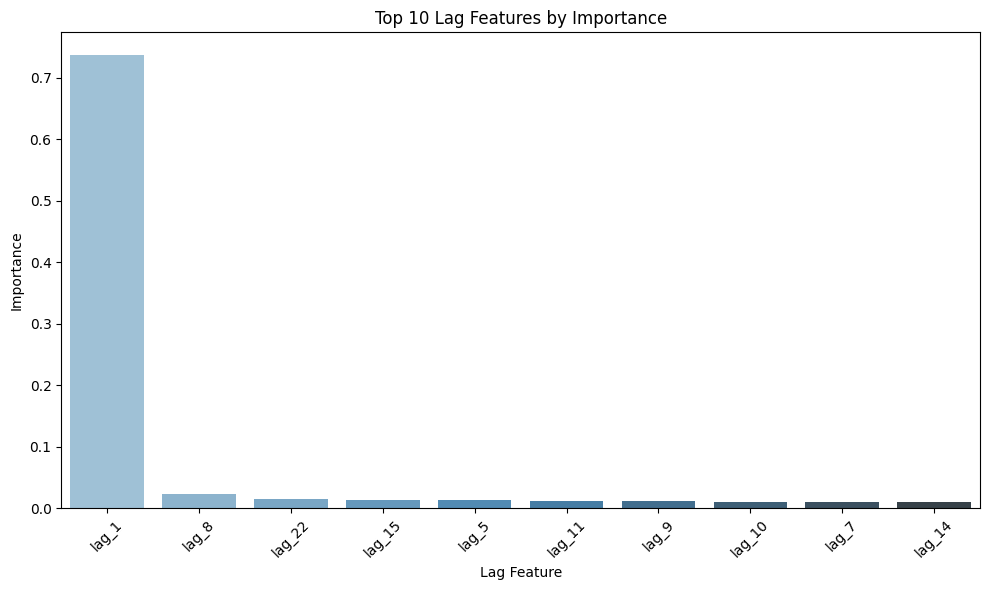

In [14]:
def plot_important_lags(importance_df, top_n=10):
    """
    Plot top lag features by importance.
    Args:
        importance_df (pd.DataFrame): DataFrame with feature importance scores.
        top_n (int): Number of top features to plot.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(top_n), x='lag', y='importance', palette='Blues_d')
    plt.title(f"Top {top_n} Lag Features by Importance")
    plt.xlabel("Lag Feature")
    plt.ylabel("Importance")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example Usage
plot_important_lags(feature_importance, top_n=10)


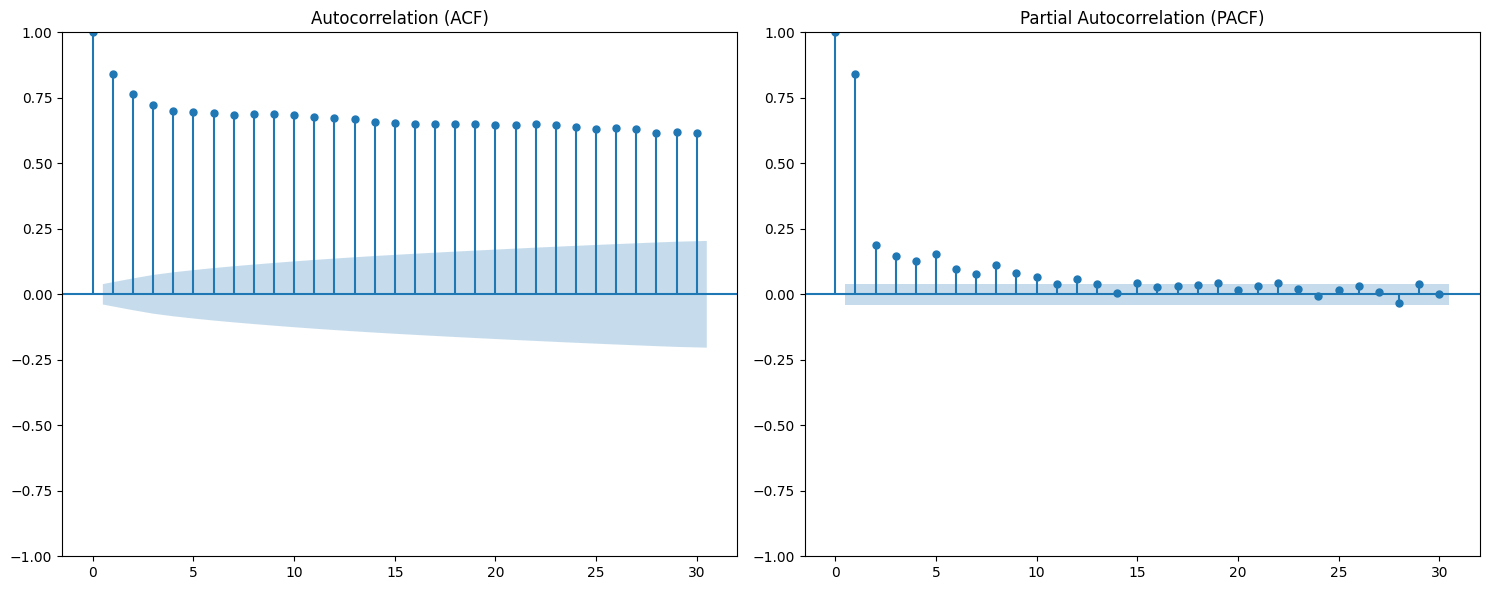

In [15]:
# Plot ACF and PACF
def plot_acf_pacf(series, lags=30):
    """
    Plot ACF and PACF for the given series.
    Args:
        series (pd.Series): Time series data.
        lags (int): Number of lags to plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title("Autocorrelation (ACF)")
    plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation (PACF)")
    plt.tight_layout()
    plt.show()

# Example Usage
plot_acf_pacf(df["Volume"])


# Forecasting using ARIMA

In [16]:
model = ARIMA(df['Close'], order=(5,1,0))
arima_result = model.fit()

# Summary of the model
print(arima_result.summary())

# Forecasting
forecast = arima_result.forecast(steps=10)
print(forecast)


c:\All\Programming\DataScience\End-To-End project\Apple Stock\AppleStockForecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\All\Programming\DataScience\End-To-End project\Apple Stock\AppleStockForecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

c:\All\Programming\DataScience\End-To-End project\Apple Stock\AppleStockForecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\All\Programming\DataScience\End-To-End project\Apple Stock\AppleStockForecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2518
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5425.188
Date:                Fri, 27 Dec 2024   AIC                          10862.376
Time:                        20:42:25   BIC                          10897.361
Sample:                             0   HQIC                         10875.073
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0172      0.012      1.473      0.141      -0.006       0.040
ar.L2         -0.0329      0.011     -3.108      0.002      -0.054      -0.012
ar.L3         -0.0212      0.010     -2.102      0.0

c:\All\Programming\DataScience\End-To-End project\Apple Stock\AppleStockForecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\All\Programming\DataScience\End-To-End project\Apple Stock\AppleStockForecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



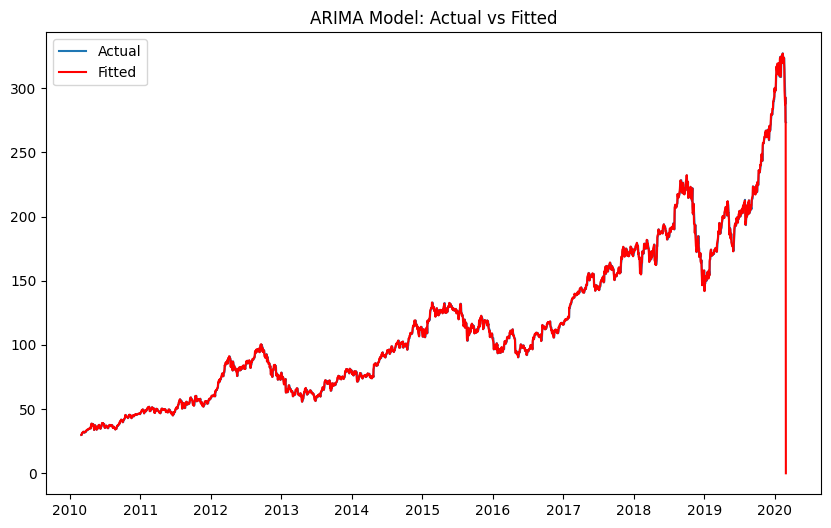

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label="Actual")
plt.plot(arima_result.fittedvalues, label="Fitted", color='red')
plt.title("ARIMA Model: Actual vs Fitted")
plt.legend()
plt.show()


# Forecasting using LSTM


In [18]:
# Define a function to create sequences
def create_sequences(data, time_steps=60):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:i + time_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(x), np.array(y)

In [19]:
# Select the target column (e.g., 'Close')
data = df[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define a function to create sequences
def create_sequences(data, time_steps=60):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:i + time_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(x), np.array(y)

# Create sequences
time_steps = 60  # Look-back period (e.g., 60 days)
x, y = create_sequences(scaled_data, time_steps)

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Reshape input to [samples, time_steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [20]:
# Create sequences
time_steps = 60  # Look-back period (e.g., 60 days)
x, y = create_sequences(scaled_data, time_steps)

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Reshape input to [samples, time_steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [21]:
# Initialize the model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add dense layers
model.add(Dense(units=25))
model.add(Dense(units=1))  # Single output for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

c:\All\Programming\DataScience\End-To-End project\Apple Stock\AppleStockForecast\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


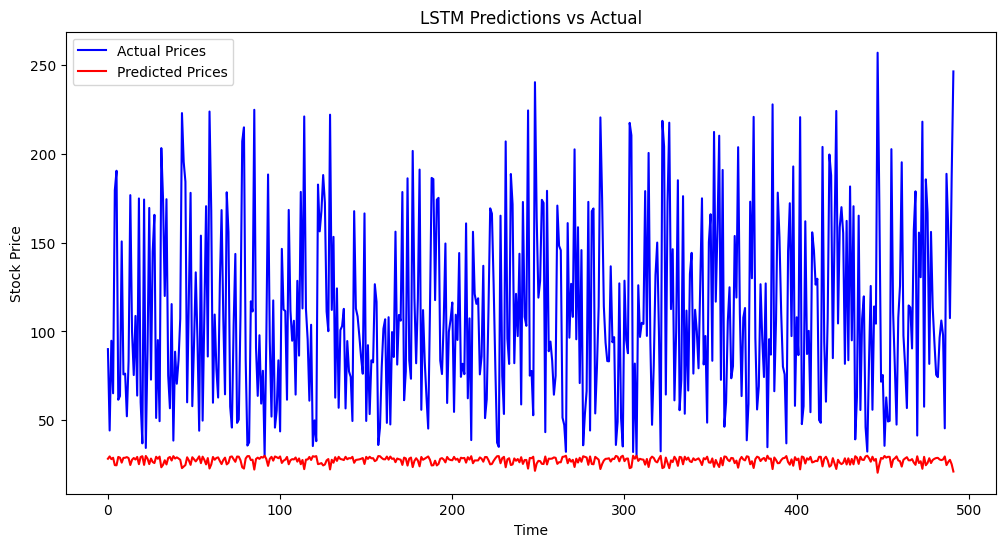

In [22]:
# Predict on the test set
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # Convert back to original scale

# Inverse transform the test labels
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Wrong LSTM


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


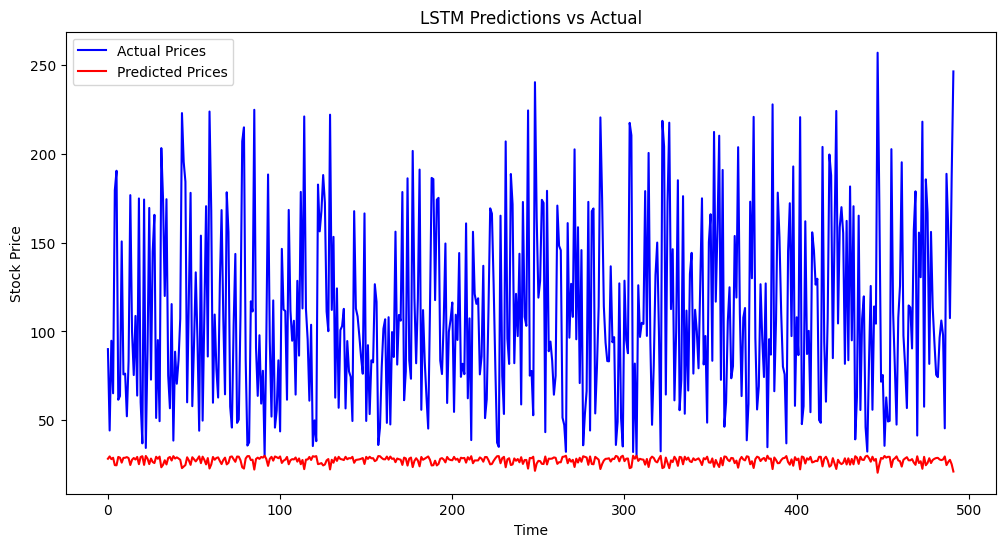

In [23]:
# Predict on the test set
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # Convert back to original scale

# Inverse transform the test labels
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



Epoch 1/50


c:\All\Programming\DataScience\End-To-End project\Apple Stock\AppleStockForecast\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0245 - val_loss: 2.2595e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0013 - val_loss: 2.0420e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 9.8376e-04 - val_loss: 2.6488e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 9.6801e-04 - val_loss: 2.4050e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 8.6464e-04 - val_loss: 1.7990e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 7.9237e-04 - val_loss: 2.0067e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 7.6228e-04 - val_loss: 2.3304e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.4542e-04 - val_loss: 3.1125e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.0645e-04 - val_loss: 2.2760e-04
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.1070e-04 - val_loss: 1.6841e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 5.2464e-04 - val_loss: 1.643

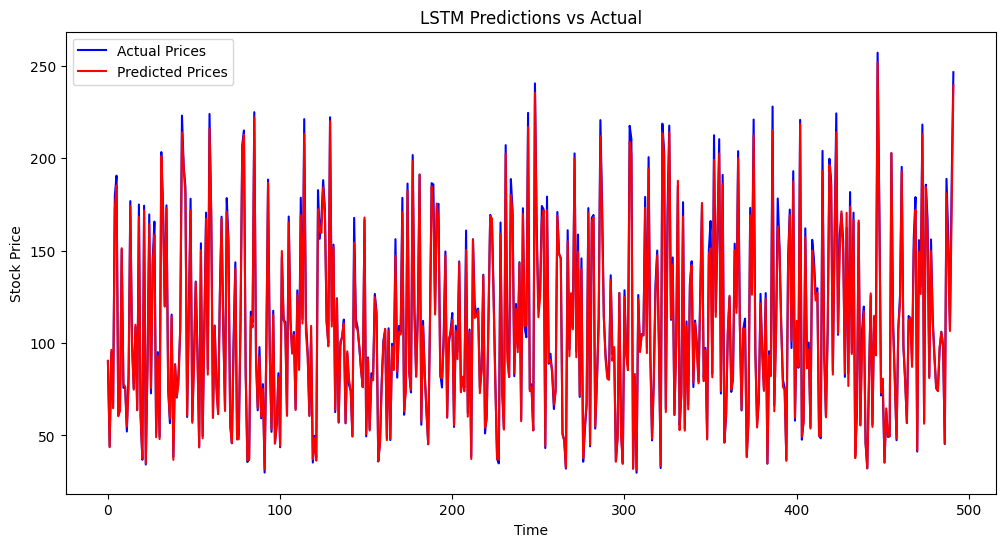

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Define evaluation function
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluates the performance of a time series model.

    Args:
    y_true (array-like): Actual values.
    y_pred (array-like): Predicted values.
    model_name (str): Name of the model being evaluated.

    Returns:
    dict: A dictionary with evaluation metrics.
    """
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    
    # Print evaluation results
    print(f"\n{model_name} Evaluation Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R-Squared: {r2:.4f}")
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual Prices', color='blue', alpha=0.7)
    plt.plot(y_pred, label='Predicted Prices', color='orange', alpha=0.7)
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid()
    plt.show()
    
    return {"RMSE": rmse, "MAPE": mape, "R2": r2}

# Evaluate the model
metrics = evaluate_model(y_test_scaled.flatten(), predictions.flatten(), model_name="LSTM Model")

# Print metrics dictionary (optional, for further use in a report or logging)
print(metrics)


c:\All\Programming\DataScience\End-To-End project\Apple Stock\AppleStockForecast\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0127 - val_loss: 5.3457e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0018 - val_loss: 3.9673e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0014 - val_loss: 3.3811e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 9.7086e-04 - val_loss: 2.8355e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 8.5244e-04 - val_loss: 3.5902e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 8.4811e-04 - val_loss: 3.4850e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 8.2114e-04 - val_loss: 1.6239e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 5.9292e-04 - val_loss: 1.7181e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 7.5431e-04 - val_loss: 1.4095e-04
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 6.4053e-04 - val_loss: 5.2758e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 7.9293e-04 - val_loss

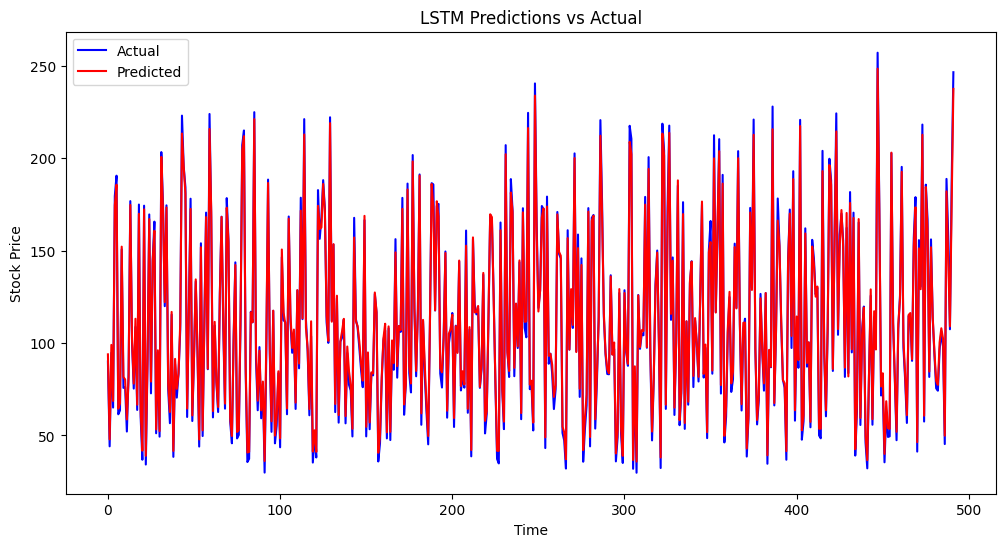

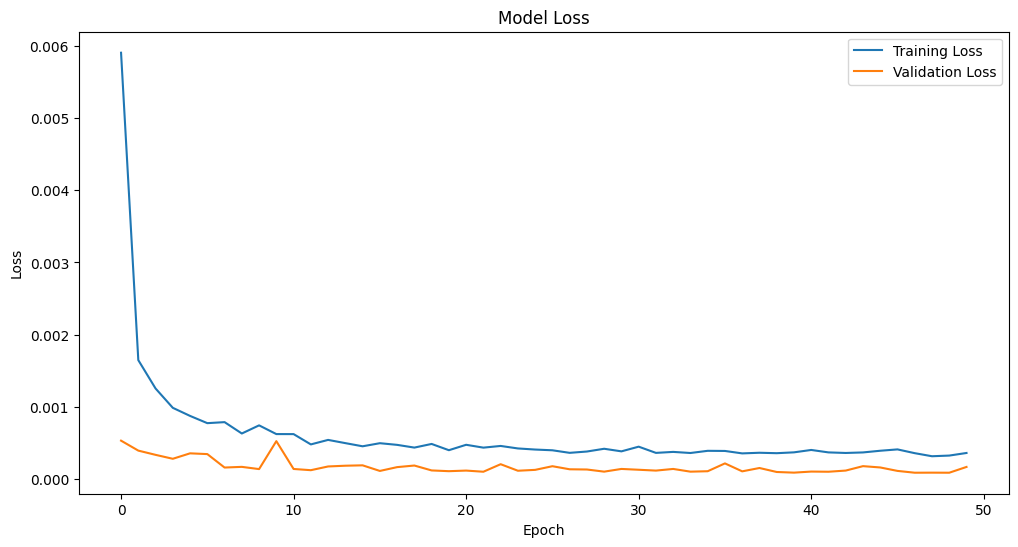

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_split import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prepare data
data = df[['Close', 'Open', 'Volume', 'High', 'Low']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_sequences(data, time_steps=60):
   x, y = [], []
   for i in range(len(data) - time_steps):
       x.append(data[i:i + time_steps])
       y.append(data[i + time_steps, 0])
   return np.array(x), np.array(y)

# Create sequences
x, y = create_sequences(scaled_data, time_steps=60)

# Split and reshape
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Model
model = Sequential([
   LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 5)),
   Dropout(0.2),
   LSTM(50, return_sequences=False),
   Dropout(0.2),
   Dense(25),
   Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history = model.fit(
   x_train, y_train,
   epochs=50,
   batch_size=32,
   validation_split=0.1,
   verbose=1
)

# Predict
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(
   np.hstack([predictions, np.zeros((predictions.shape[0], 4))])
)[:, 0]
y_test_scaled = scaler.inverse_transform(
   np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 4))])
)[:, 0]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, 'b-', label='Actual')
plt.plot(predictions, 'r-', label='Predicted')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Load your latest data point
last_60_days = df[['Close', 'Open', 'Volume', 'High', 'Low']].values[-60:]
last_60_days_scaled = scaler.transform(last_60_days)

# Reshape
X_predict = np.array([last_60_days_scaled])

# Make prediction
prediction = model.predict(X_predict)
final_prediction = scaler.inverse_transform(
   np.hstack([prediction, np.zeros((prediction.shape[0], 4))])
)[:, 0][0]

print(f"Next day's predicted price: ${final_prediction:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Next day's predicted price: $35.16


In [27]:
df.tail()

,Close,Volume,Open,High,Low,year,month,week,day,day_str,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-05,31.2786,224647427,30.7057,31.3857,30.6614,2010,3,9,4,Fri,...,111431983.0,156909177.0,142899723.0,83443105.0,83236885.0,76184103.0,100827750.0,93876048.0,187514026.0,141571402.0
2010-03-04,30.1014,89591907,29.8971,30.1314,29.8043,2010,3,9,3,Thu,...,170363601.0,111431983.0,156909177.0,142899723.0,83443105.0,83236885.0,76184103.0,100827750.0,93876048.0,187514026.0
2010-03-03,29.9043,92846488,29.8486,29.9814,29.7057,2010,3,9,2,Wed,...,150568295.0,170363601.0,111431983.0,156909177.0,142899723.0,83443105.0,83236885.0,76184103.0,100827750.0,93876048.0
2010-03-02,29.8357,141486282,29.9900,30.1186,29.6771,2010,3,9,1,Tue,...,107438412.0,150568295.0,170363601.0,111431983.0,156909177.0,142899723.0,83443105.0,83236885.0,76184103.0,100827750.0
2010-03-01,29.8557,137312041,29.3928,29.9286,29.3500,2010,3,9,0,Mon,...,131326339.0,107438412.0,150568295.0,170363601.0,111431983.0,156909177.0,142899723.0,83443105.0,83236885.0,76184103.0


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluates the performance of a time series model.

    Args:
    y_true (array-like): Actual values.
    y_pred (array-like): Predicted values.
    model_name (str): Name of the model being evaluated.

    Returns:
    dict: A dictionary with evaluation metrics.
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    
    # Print evaluation results
    print(f"\n{model_name} Evaluation Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R-Squared: {r2:.4f}")
    
    # Return metrics as a dictionary
    metrics = {
        "RMSE": rmse,
        "MAPE": mape,
        "R-Squared": r2
    }
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual', color='blue', alpha=0.7)
    plt.plot(y_pred, label='Predicted', color='orange', alpha=0.7)
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return metrics


LSTM Model Evaluation Results:
RMSE: 4.0859
MAPE: 3.95%
R-Squared: 0.9937


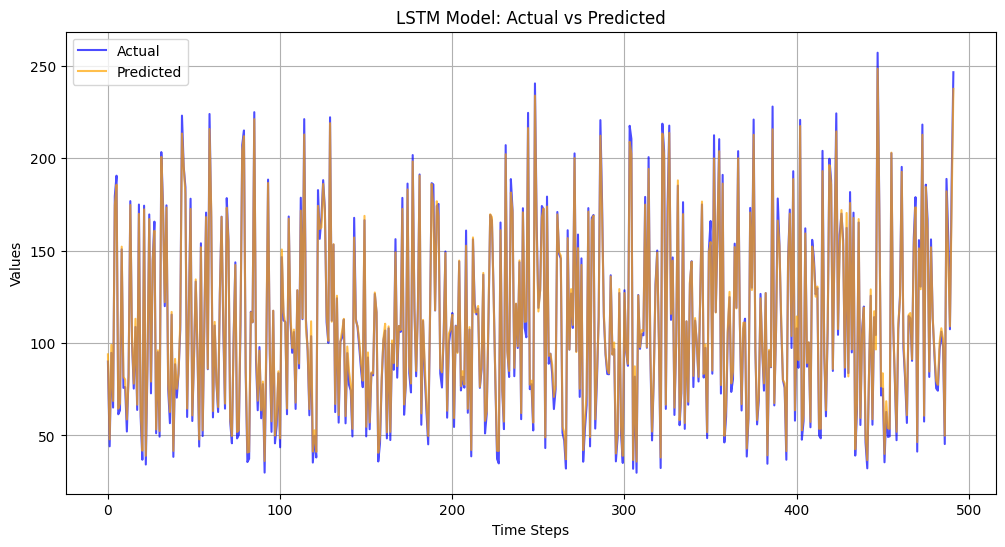

{'RMSE': np.float64(4.085922828855107), 'MAPE': 3.950851088558676, 'R-Squared': 0.9936569661366403}


In [29]:
metrics = evaluate_model(y_test_scaled.flatten(), predictions.flatten(), model_name="LSTM Model")

# Print metrics dictionary (optional, for further use in a report or logging)
print(metrics)